In [1]:
import pandas as pd
import json
import re
import matplotlib.pyplot as plt
import seaborn as sns

Get Actual Valence classification dataset with parsed column

In [2]:
input_dir = '../datasets/llm_outputs/valence'

fp_actual = f'{input_dir}/2024_coherent_valence_classification.csv'
df_actual = pd.read_csv(fp_actual)

In [3]:
def parse_classification(raw_resp):
    regex = r'"classification":\s*"([^"]+)"'
    match = re.search(regex, raw_resp)
    if match:
        return match.group(1)
    else:
        return None

In [4]:
df_actual['valence'] = df_actual['valence_classification_raw'].apply(parse_classification)
df_actual.head()

,Unnamed: 0,question_id,transcript_id,question_addressee,justice,question_text,opening_statement,full_text,label,valence_classification_raw,valence
0,1,q_dd1235f1,2024.23-621-t01,petitioner,Clarence Thomas,But I thought your argument hinged on a court...,<speaker>Erika L. Maley</speaker><text> Mr. Ch...,"<speaker>John G. Roberts, Jr.</speaker><text> ...",coherent,"{\n ""classification"": ""Competitive"",\n ""reas...",Competitive
1,3,q_e843e146,2024.23-621-t01,petitioner,Elena Kagan,"Well, it's -- it's true that it's only a lik...",<speaker>Erika L. Maley</speaker><text> Mr. Ch...,"<speaker>John G. Roberts, Jr.</speaker><text> ...",coherent,"{\n""classification"": ""Very Competitive"",\n""rea...",Very Competitive
2,4,q_e052c4b2,2024.23-621-t01,petitioner,Ketanji Brown Jackson,But it's not that determination that's making...,<speaker>Erika L. Maley</speaker><text> Mr. Ch...,"<speaker>John G. Roberts, Jr.</speaker><text> ...",coherent,"{\n ""classification"": ""Competitive"",\n ""...",Competitive
3,5,q_6a41e1e0,2024.23-621-t01,petitioner,Ketanji Brown Jackson,When you think about the difference between m...,<speaker>Erika L. Maley</speaker><text> Mr. Ch...,"<speaker>John G. Roberts, Jr.</speaker><text> ...",coherent,"{\n""classification"": ""Competitive"",\n""reasonin...",Competitive
4,7,q_8ddfdd01,2024.23-621-t01,petitioner,Ketanji Brown Jackson,But didn't Sole open -- leave open that --th...,<speaker>Erika L. Maley</speaker><text> Mr. Ch...,"<speaker>John G. Roberts, Jr.</speaker><text> ...",coherent,"{\n""classification"": ""Competitive"",\n""reasonin...",Competitive


Llama 8B

In [ ]:
dir = '/scratch/gpfs/nnadeem/llms-for-oral-arguments/finetune/outputs/OS_questions/processed/metrics'
base_fp = f'{dir}/llama_8B_base_inference_compiled_all_metrics.csv' ## File from Kylie, renamed
finetuned_fp = f'{dir}/dialogue_finetuned_8B_inference_compiled_all_metrics.csv'

In [6]:
df_base = pd.read_csv(base_fp)
df_ft = pd.read_csv(finetuned_fp)
df_ft = df_ft[df_ft['is_question']] ## Filter out non-question statements

In [7]:
df_base['justice'].value_counts()

justice
jackson      106
thomas       105
alito        102
kagan        101
kavanaugh    100
roberts      100
sotomayor    100
barrett       98
gorsuch       98
Name: count, dtype: int64

In [8]:
df_ft['justice'].value_counts()

justice
justice_amy_coney_barrett        171
justice_clarence_thomas          165
justice_brett_m_kavanaugh        161
justice_elena_kagan              158
justice_samuel_a_alito_jr        155
justice_sonia_sotomayor          154
justice_ketanji_brown_jackson    152
justice_neil_gorsuch             117
justice_john_g_roberts_jr        112
Name: count, dtype: int64

In [9]:
df_actual['justice'].value_counts()

justice
Ketanji Brown Jackson    113
Sonia Sotomayor           73
Brett M. Kavanaugh        63
Neil Gorsuch              62
Elena Kagan               60
Samuel A. Alito, Jr.      56
Clarence Thomas           43
John G. Roberts, Jr.      40
Amy Coney Barrett         29
Name: count, dtype: int64

In [10]:
df_actual.columns

Index(['Unnamed: 0', 'question_id', 'transcript_id', 'question_addressee',
       'justice', 'question_text', 'opening_statement', 'full_text', 'label',
       'valence_classification_raw', 'valence'],
      dtype='object')

**Standardize justice names across all 3 dataframes**:

In [11]:
def standardize_justice_names(df, col='justice'):
    mapping = {
        # Short names in df_base
        'jackson': 'Ketanji Brown Jackson',
        'thomas': 'Clarence Thomas',
        'alito': 'Samuel A. Alito, Jr.',
        'kagan': 'Elena Kagan',
        'kavanaugh': 'Brett M. Kavanaugh',
        'roberts': 'John G. Roberts, Jr.',
        'sotomayor': 'Sonia Sotomayor',
        'barrett': 'Amy Coney Barrett',
        'gorsuch': 'Neil Gorsuch',

        # Lowercase snake_case style in df_ft
        'justice_ketanji_brown_jackson': 'Ketanji Brown Jackson',
        'justice_clarence_thomas': 'Clarence Thomas',
        'justice_samuel_a_alito_jr': 'Samuel A. Alito, Jr.',
        'justice_elena_kagan': 'Elena Kagan',
        'justice_brett_m_kavanaugh': 'Brett M. Kavanaugh',
        'justice_john_g_roberts_jr': 'John G. Roberts, Jr.',
        'justice_sonia_sotomayor': 'Sonia Sotomayor',
        'justice_amy_coney_barrett': 'Amy Coney Barrett',
        'justice_neil_gorsuch': 'Neil Gorsuch',

        # Full names in df_actual (map to themselves)
        'Ketanji Brown Jackson': 'Ketanji Brown Jackson',
        'Clarence Thomas': 'Clarence Thomas',
        'Samuel A. Alito, Jr.': 'Samuel A. Alito, Jr.',
        'Elena Kagan': 'Elena Kagan',
        'Brett M. Kavanaugh': 'Brett M. Kavanaugh',
        'John G. Roberts, Jr.': 'John G. Roberts, Jr.',
        'Sonia Sotomayor': 'Sonia Sotomayor',
        'Amy Coney Barrett': 'Amy Coney Barrett',
        'Neil Gorsuch': 'Neil Gorsuch',
    }
    
    return df.copy().assign(**{col: df[col].map(mapping)})


In [12]:
df_base = standardize_justice_names(df_base)
df_ft = standardize_justice_names(df_ft)
df_actual = standardize_justice_names(df_actual)

In [13]:
df_base.head()

,Unnamed: 0,question_id,transcript_id,question_addressee,justice,opening_statement,question_text,full_text,valence,legalbench,metacog
0,0,q_8728fa1b,2024.23-621-t01,petitioner,Brett M. Kavanaugh,<speaker>Erika L. Maley</speaker><text> Mr. Ch...,You argue that a preliminary injunction does n...,"<speaker>John G. Roberts, Jr.</speaker><text> ...",Competitive,Implications,argumentation_and_clarification
1,1,q_5cb7b5c9,2024.23-621-t01,petitioner,Brett M. Kavanaugh,<speaker>Erika L. Maley</speaker><text> Mr. Ch...,How do you respond to the argument that the pu...,"<speaker>John G. Roberts, Jr.</speaker><text> ...",Competitive,Criticism,argumentation_and_clarification
2,2,q_c6bffd9f,2024.23-621-t01,petitioner,Brett M. Kavanaugh,<speaker>Erika L. Maley</speaker><text> Mr. Ch...,You cite to legal dictionaries from the time o...,"<speaker>John G. Roberts, Jr.</speaker><text> ...",Competitive,Criticism,statutory_interpretation
3,3,q_9b18b63e,2024.23-621-t01,petitioner,Brett M. Kavanaugh,<speaker>Erika L. Maley</speaker><text> Mr. Ch...,Your proposed bright-line rule would seem to c...,"<speaker>John G. Roberts, Jr.</speaker><text> ...",Competitive,Criticism,precedent_and_doctrine
4,4,q_34e89a7e,2024.23-365 -t01,petitioner,Brett M. Kavanaugh,<speaker>Lisa S. Blatt</speaker><text> Thank y...,"Counsel, you argue that RICO excludes damages ...","<speaker>John G. Roberts, Jr.</speaker><text> ...",Competitive,Clarification,statutory_interpretation


## Plots

In [14]:
# Select and rename relevant columns for merging
df_actual_valence = df_actual[['transcript_id', 'justice', 'valence']].copy()
df_actual_valence['source'] = 'Actual'

df_base_valence = df_base[['transcript_id', 'justice', 'valence']].copy()
df_base_valence['source'] = 'Base Llama-8B'

df_ft_valence = df_ft[['transcript_id', 'justice', 'valence']].copy()
df_ft_valence['source'] = 'Finetuned Llama-8B'

# Combine all datasets
combined_valence = pd.concat([df_actual_valence, df_base_valence, df_ft_valence], ignore_index=True)


In [15]:
combined_valence.head()

,transcript_id,justice,valence,source
0,2024.23-621-t01,Clarence Thomas,Competitive,Actual
1,2024.23-621-t01,Elena Kagan,Very Competitive,Actual
2,2024.23-621-t01,Ketanji Brown Jackson,Competitive,Actual
3,2024.23-621-t01,Ketanji Brown Jackson,Competitive,Actual
4,2024.23-621-t01,Ketanji Brown Jackson,Competitive,Actual


In [16]:
# Group by and count occurrences
combined_valence_proportions = (
    combined_valence.groupby(['justice', 'transcript_id', 'source', 'valence'])
    .size()
    .reset_index(name='count')
)

# Calculate proportions
combined_valence_proportions['proportion'] = combined_valence_proportions.groupby(
    ['justice', 'transcript_id', 'source']
)['count'].transform(lambda x: x / x.sum())

In [17]:
combined_valence_proportions.head()

,justice,transcript_id,source,valence,count,proportion
0,Amy Coney Barrett,2024.22-7466,Finetuned Llama-8B,Competitive,4,0.285714
1,Amy Coney Barrett,2024.22-7466,Finetuned Llama-8B,Neutral,10,0.714286
2,Amy Coney Barrett,2024.22-7466-t01,Actual,Competitive,1,0.333333
3,Amy Coney Barrett,2024.22-7466-t01,Actual,Neutral,2,0.666667
4,Amy Coney Barrett,2024.22-7466-t01,Base Llama-8B,Competitive,5,0.714286


#### Create combined dataframe with bucketed valence categories

In [18]:
valence_mapping = {
    "Competitive": "Competitive",
    "Very Competitive": "Competitive",
    "Neutral": "Neutral",
    "Supportive": "Supportive",
    "Very Supportive": "Supportive"
}

combined_valence_bucketed = combined_valence.copy()
combined_valence_bucketed['bucketed_valence'] = combined_valence_bucketed['valence'].map(valence_mapping)
combined_valence_bucketed.head()

,transcript_id,justice,valence,source,bucketed_valence
0,2024.23-621-t01,Clarence Thomas,Competitive,Actual,Competitive
1,2024.23-621-t01,Elena Kagan,Very Competitive,Actual,Competitive
2,2024.23-621-t01,Ketanji Brown Jackson,Competitive,Actual,Competitive
3,2024.23-621-t01,Ketanji Brown Jackson,Competitive,Actual,Competitive
4,2024.23-621-t01,Ketanji Brown Jackson,Competitive,Actual,Competitive


In [19]:
# Group by and count occurrences
combined_valence_bucketed_proportions = (
    combined_valence_bucketed.groupby(['justice', 'transcript_id', 'source', 'bucketed_valence'])
    .size()
    .reset_index(name='count')
)

# Calculate proportions
combined_valence_bucketed_proportions['proportion'] = combined_valence_bucketed_proportions.groupby(
    ['justice', 'transcript_id', 'source']
)['count'].transform(lambda x: x / x.sum())

In [20]:
combined_valence_bucketed_proportions.head(-10)

,justice,transcript_id,source,bucketed_valence,count,proportion
0,Amy Coney Barrett,2024.22-7466,Finetuned Llama-8B,Competitive,4,0.285714
1,Amy Coney Barrett,2024.22-7466,Finetuned Llama-8B,Neutral,10,0.714286
2,Amy Coney Barrett,2024.22-7466-t01,Actual,Competitive,1,0.333333
3,Amy Coney Barrett,2024.22-7466-t01,Actual,Neutral,2,0.666667
4,Amy Coney Barrett,2024.22-7466-t01,Base Llama-8B,Competitive,5,0.714286
...,...,...,...,...,...,...
778,Sonia Sotomayor,2024.23-753-t01,Base Llama-8B,Neutral,2,0.285714
779,Sonia Sotomayor,2024.23-852,Finetuned Llama-8B,Competitive,7,0.538462
780,Sonia Sotomayor,2024.23-852,Finetuned Llama-8B,Neutral,6,0.461538
781,Sonia Sotomayor,2024.23-852-t01,Actual,Competitive,3,0.333333


### Plot Pie Charts

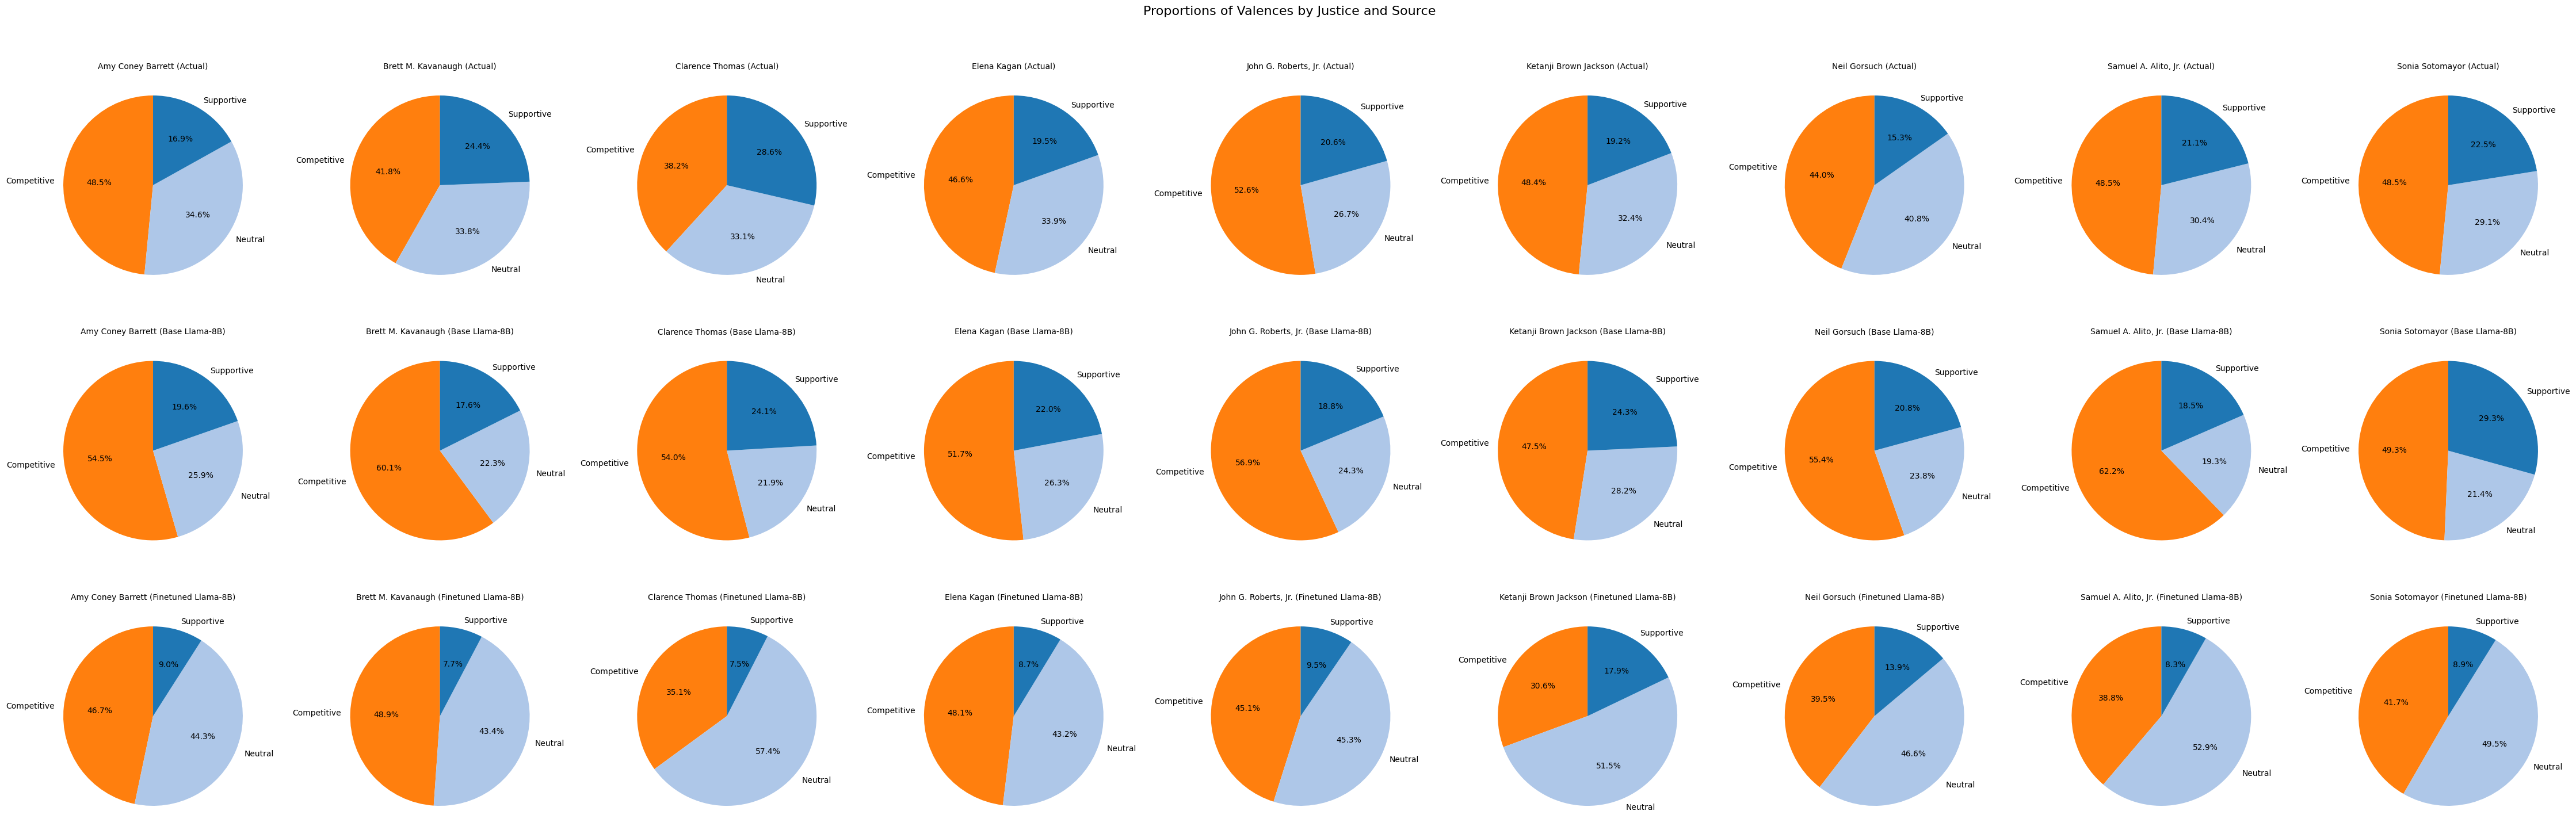

In [22]:
mean_proportions_pie = combined_valence_bucketed_proportions.groupby(['source', 'justice', 'bucketed_valence'])['proportion'].mean().reset_index()

# Reverse the valence categories for color mapping
valence_categories = mean_proportions_pie['bucketed_valence'].unique()[::-1]
color_palette = plt.cm.tab20.colors[:len(valence_categories)]
color_map = dict(zip(valence_categories, color_palette))

sources = mean_proportions_pie['source'].unique()
justices = mean_proportions_pie['justice'].unique()

# Handle single row/column edge cases
n_rows = len(sources)
n_cols = len(justices)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows), subplot_kw={'aspect': 'equal'})

# Ensure axes is always 2D array-like for uniform indexing
if n_rows == 1 and n_cols == 1:
    axes = [[axes]]
elif n_rows == 1:
    axes = [axes]
elif n_cols == 1:
    axes = [[ax] for ax in axes]

for i, source in enumerate(sources):
    for j, justice in enumerate(justices):
        ax = axes[i][j]
        subset = mean_proportions_pie[
            (mean_proportions_pie['source'] == source) &
            (mean_proportions_pie['justice'] == justice)
        ]
        
        if not subset.empty:
            colors = [color_map[val] for val in subset['bucketed_valence']]
            ax.pie(
                subset['proportion'],
                labels=subset['bucketed_valence'],
                autopct='%1.1f%%',
                startangle=90,
                colors=colors
            )
            ax.set_title(f"{justice} ({source})", fontsize=10)
        else:
            ax.axis('off')

plt.suptitle('Proportions of Valences by Justice and Source', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [23]:
def plot_valence_pie_for_justice(df, justice_name):
    # Filter for the selected justice
    subset_df = df[df['justice'] == justice_name]
    
    if subset_df.empty:
        print(f"No data found for justice: {justice_name}")
        return

    # Reverse valence categories for consistent color mapping
    valence_categories = df['bucketed_valence'].unique()[::-1]
    color_palette = plt.cm.tab20.colors[:len(valence_categories)]
    color_map = dict(zip(valence_categories, color_palette))

    sources = subset_df['source'].unique()

    fig, axes = plt.subplots(1, len(sources), figsize=(4.5 * len(sources), 4.5), subplot_kw={'aspect': 'equal'})

    # Make axes iterable even for one subplot
    if len(sources) == 1:
        axes = [axes]

    for i, source in enumerate(sources):
        ax = axes[i]
        data = subset_df[subset_df['source'] == source]

        if not data.empty:
            colors = [color_map[val] for val in data['bucketed_valence']]
            ax.pie(
                data['proportion'],
                labels=data['bucketed_valence'],
                autopct='%1.1f%%',
                startangle=90,
                colors=colors
            )
            ax.set_title(f"{justice_name} ({source})", fontsize=12)
        else:
            ax.axis('off')

    plt.suptitle(f"Valence Proportions for Justice {justice_name}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.savefig(f'figures/finetune_analysis/valence_{justice}.png')
    plt.show()


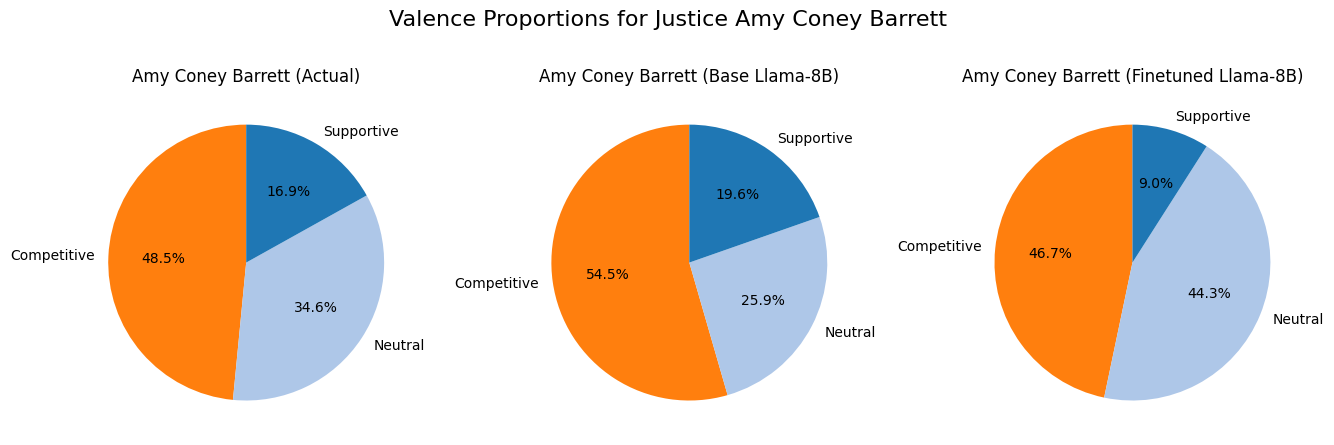

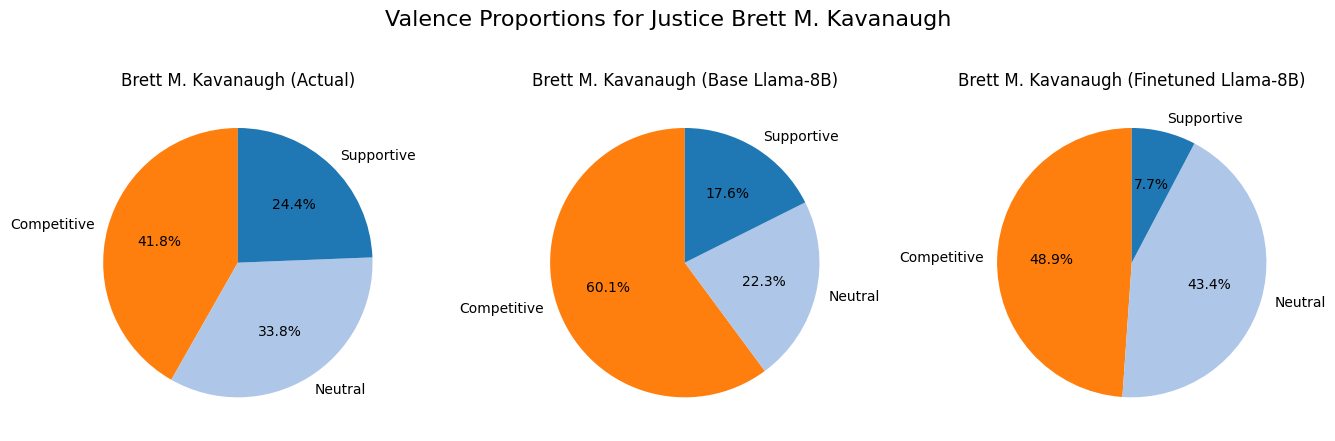

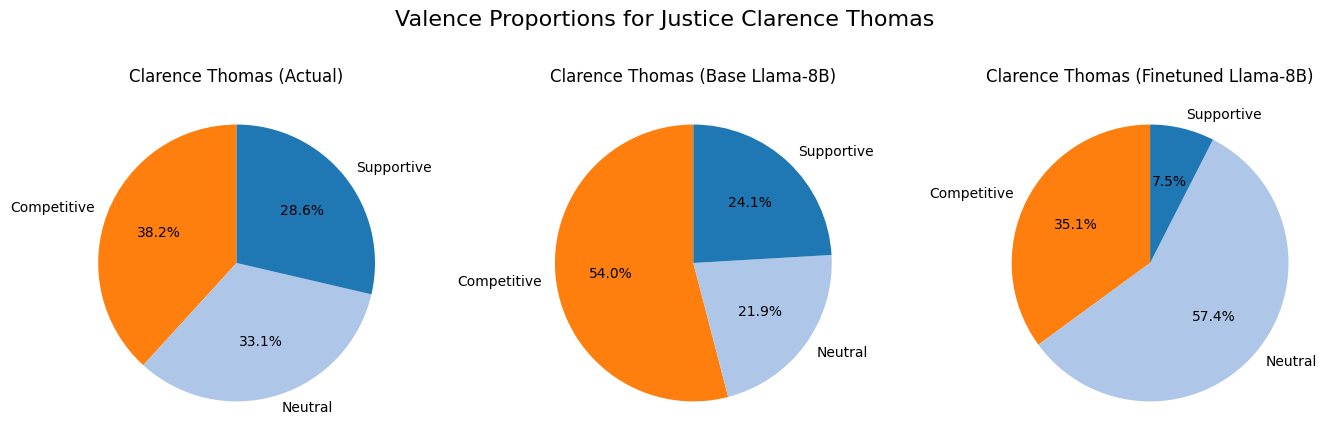

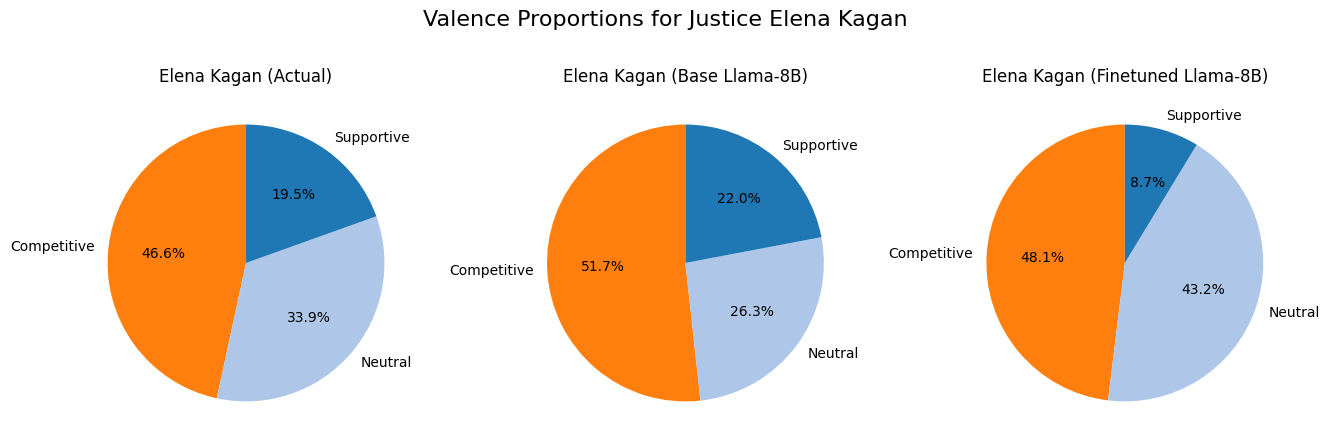

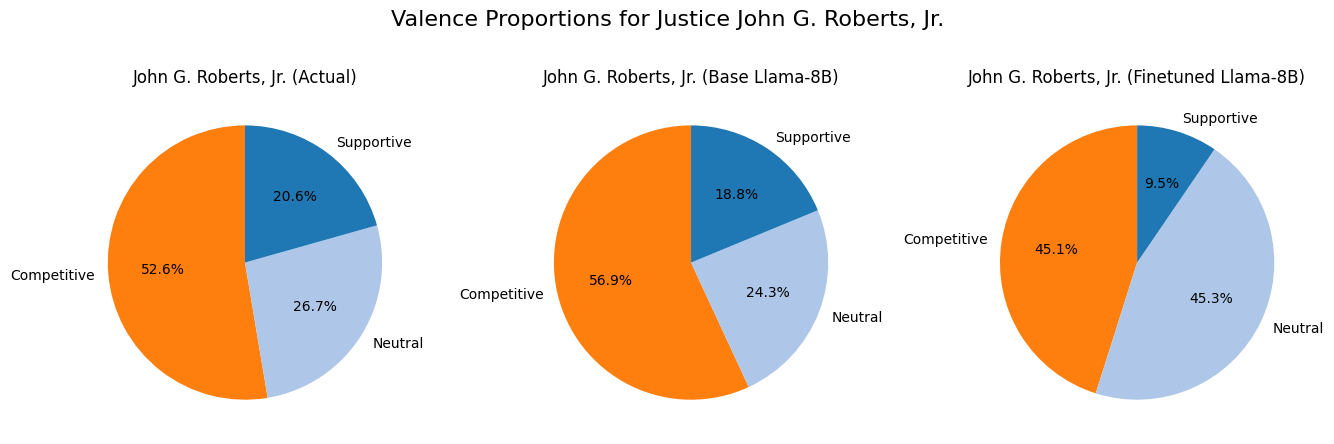

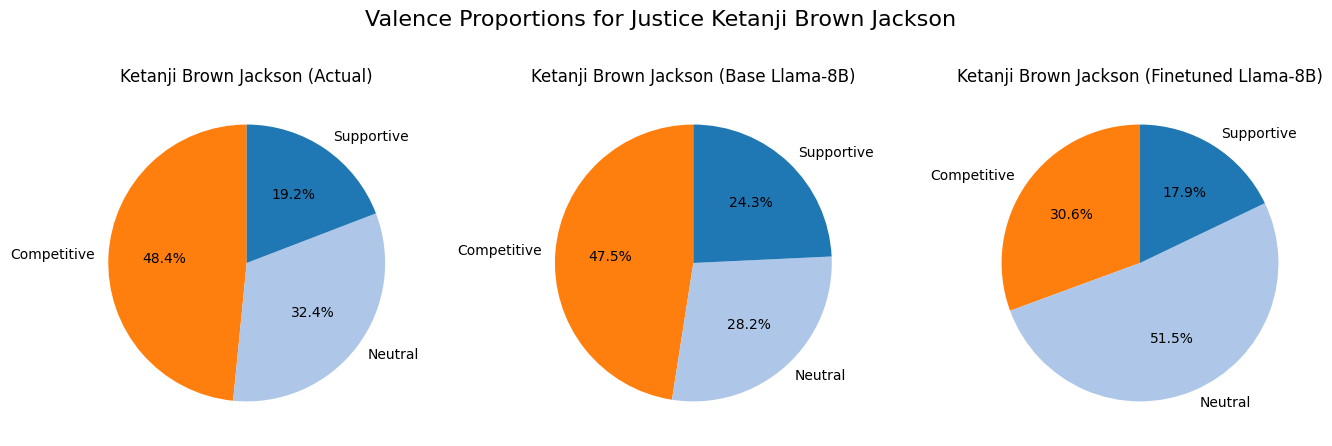

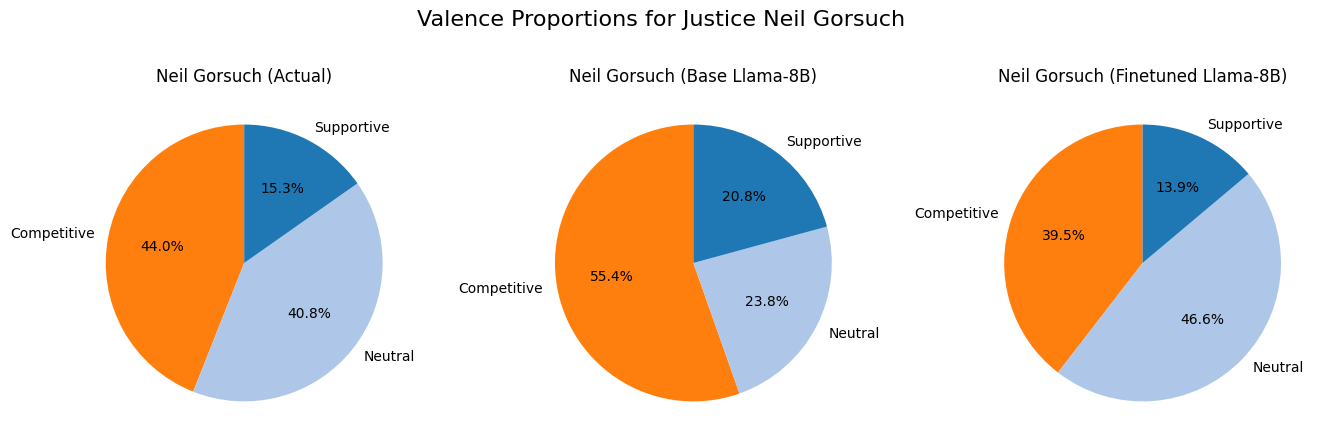

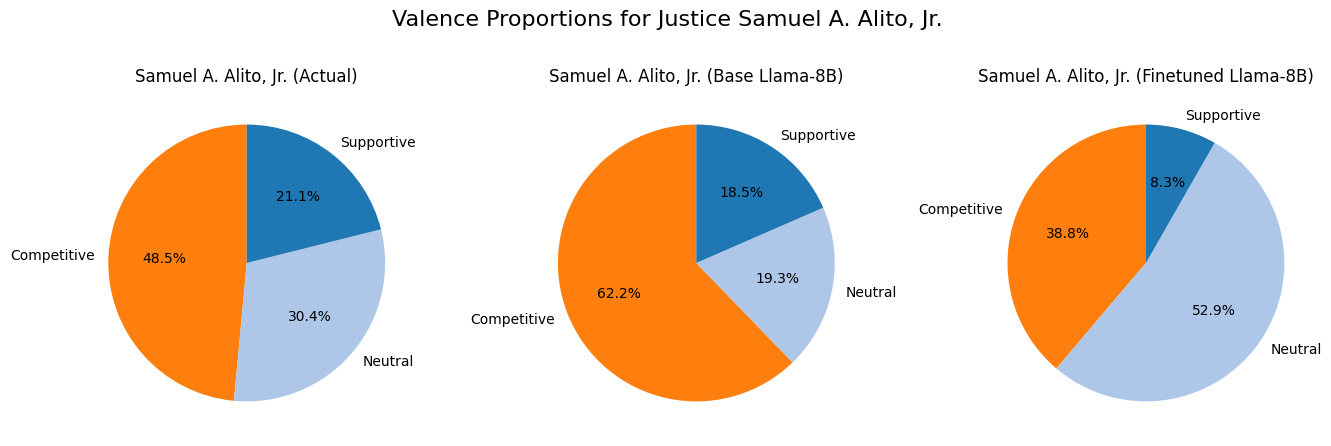

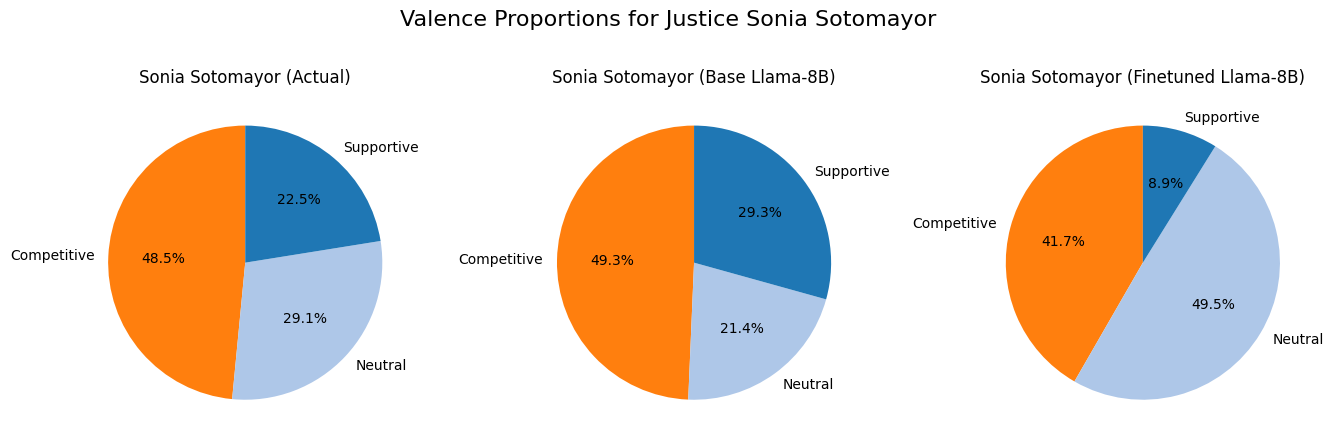

In [24]:
for justice in combined_valence_bucketed_proportions['justice'].unique():
    plot_valence_pie_for_justice(mean_proportions_pie, justice)


## Heatmaps

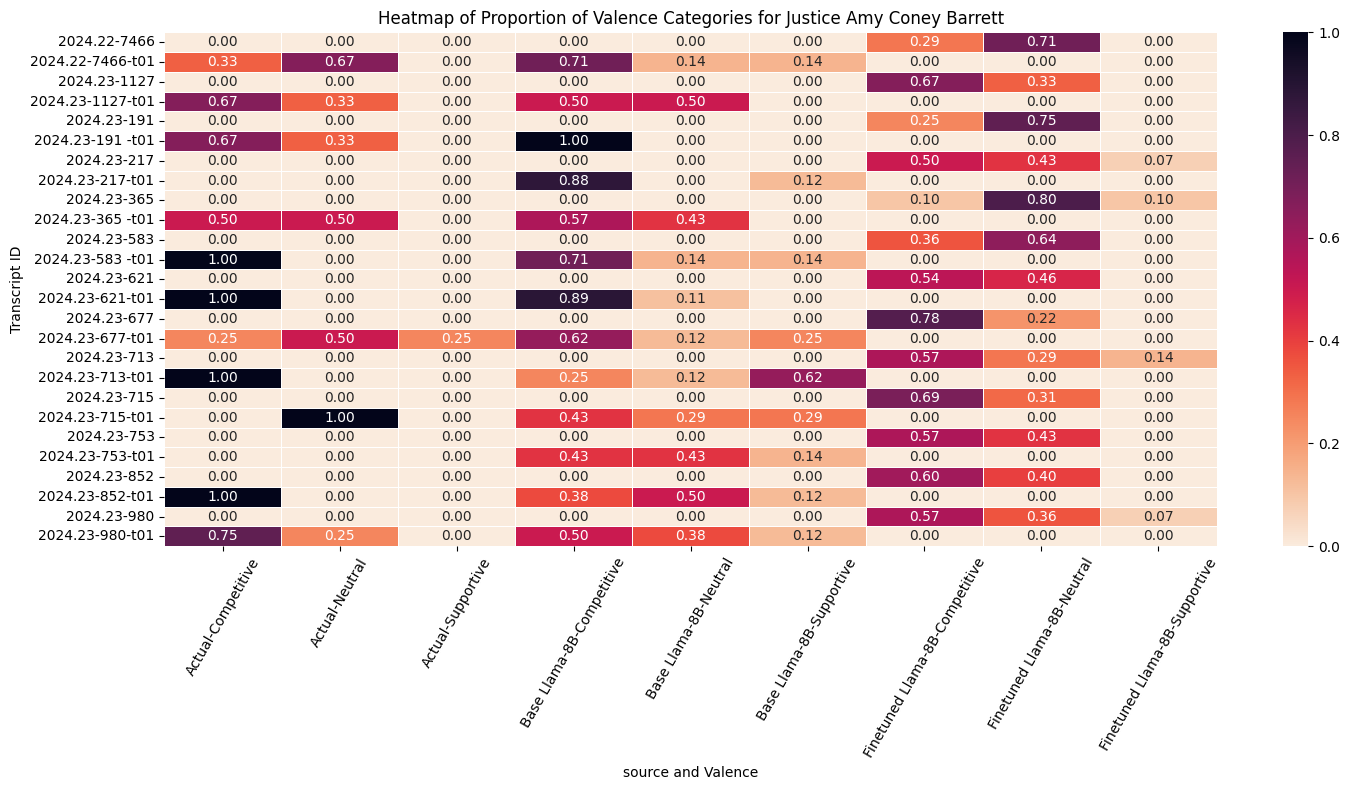

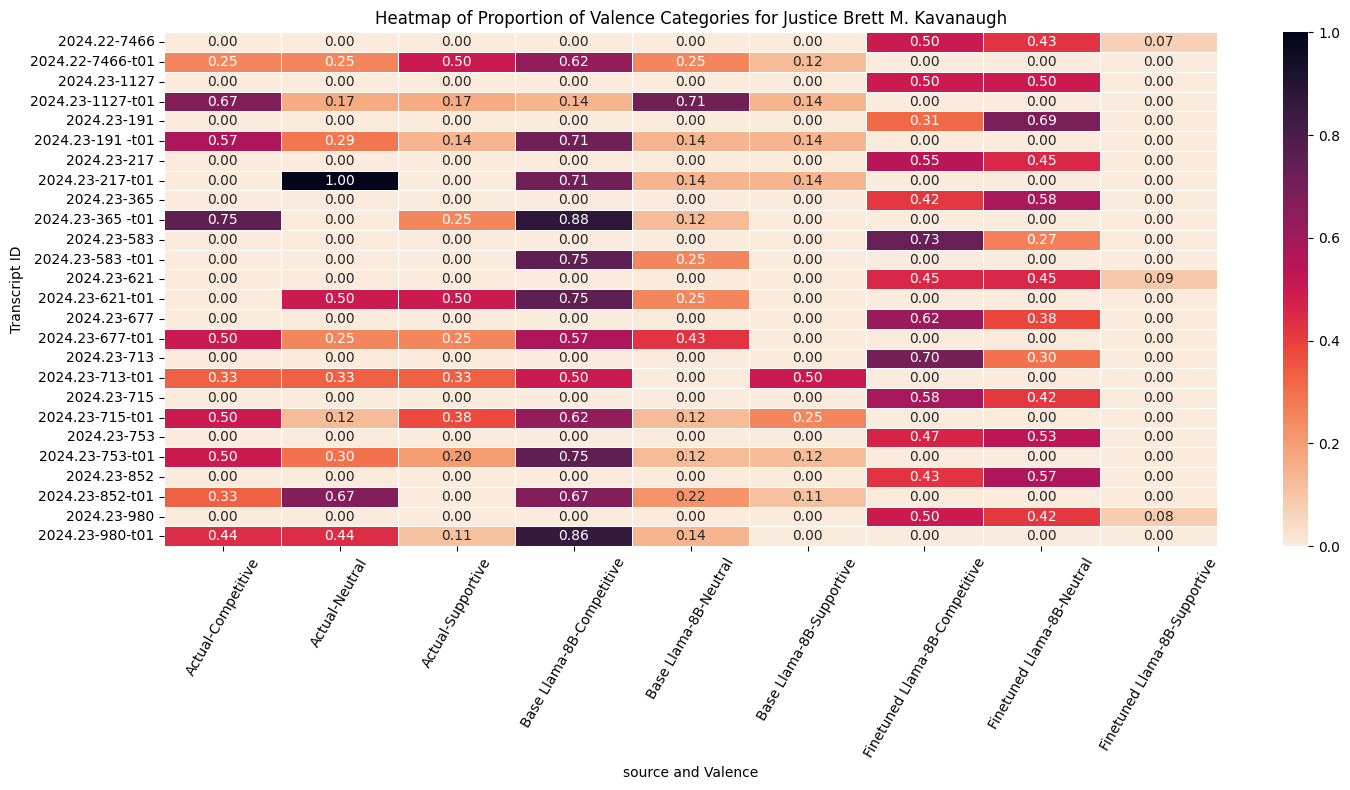

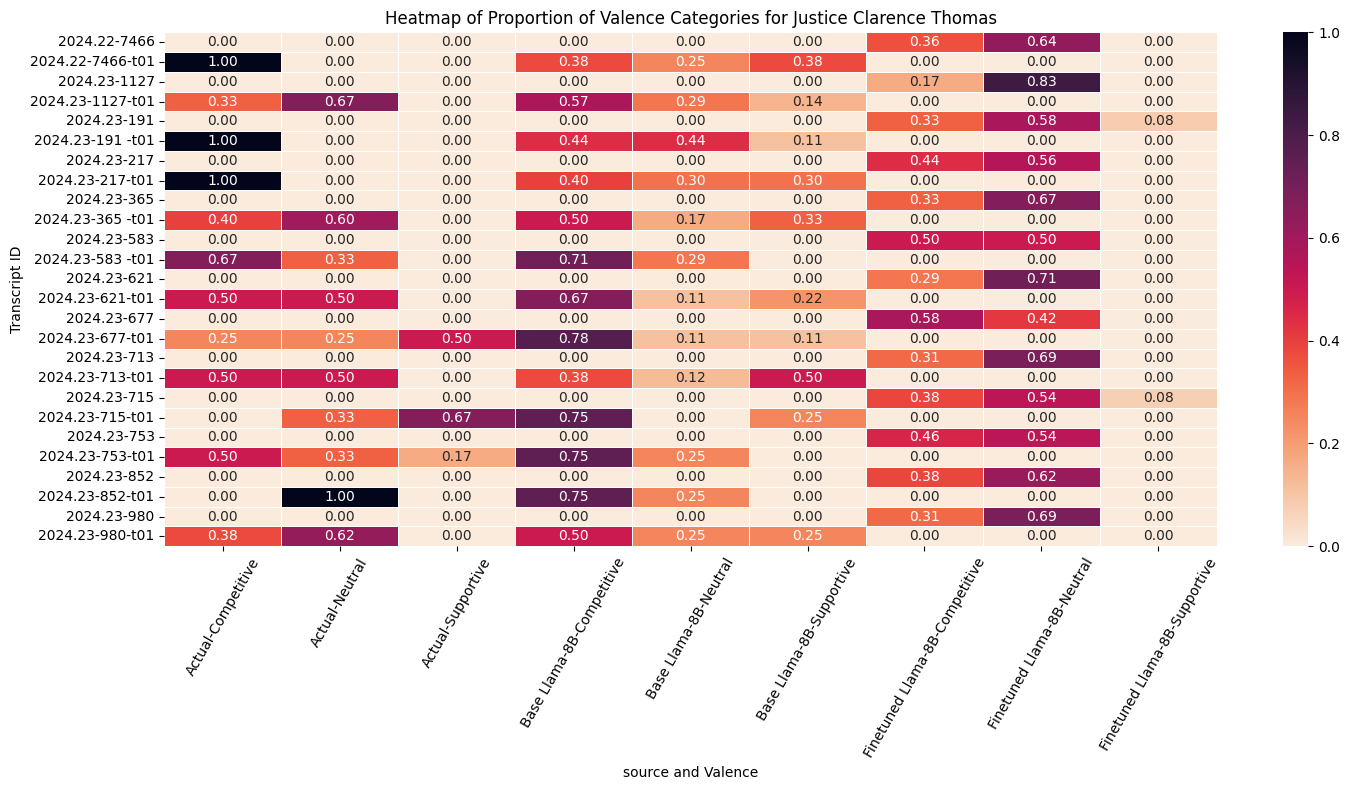

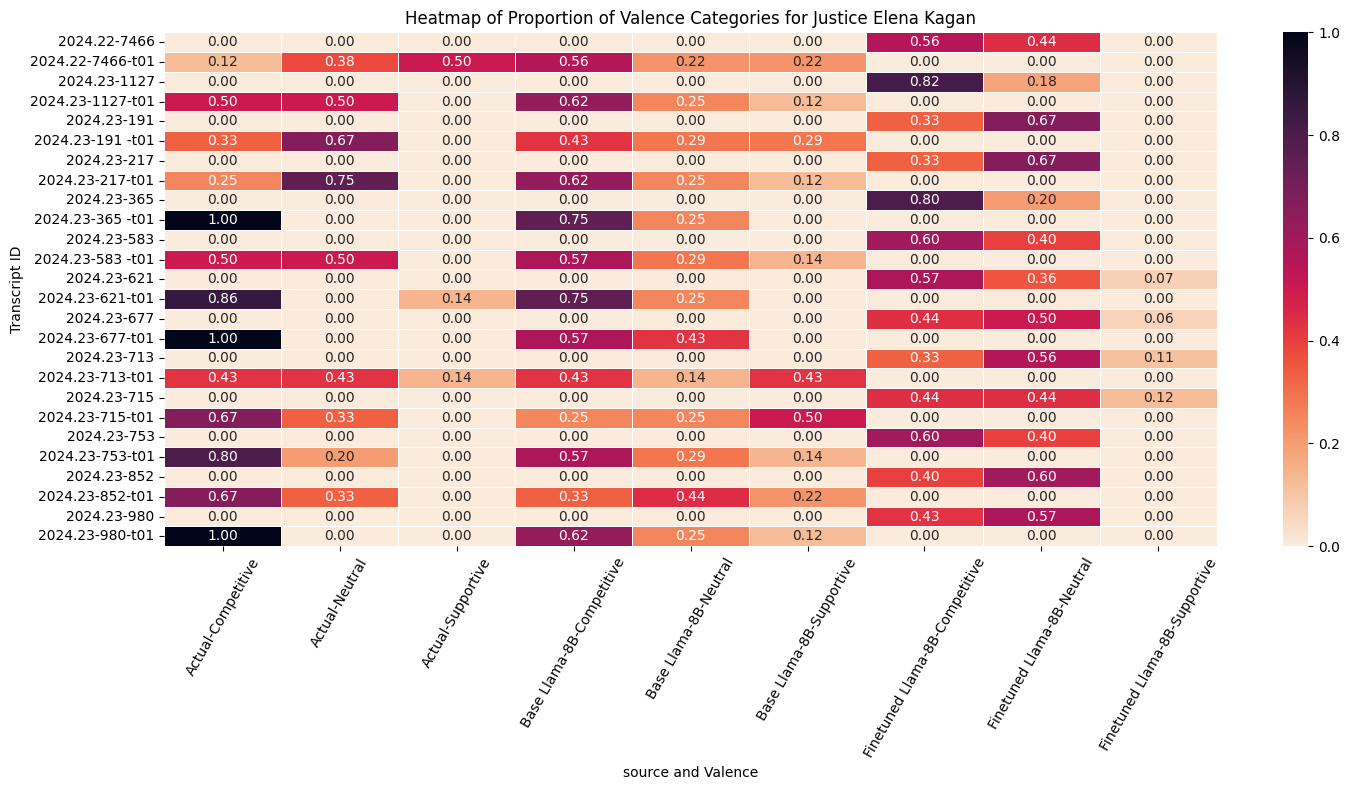

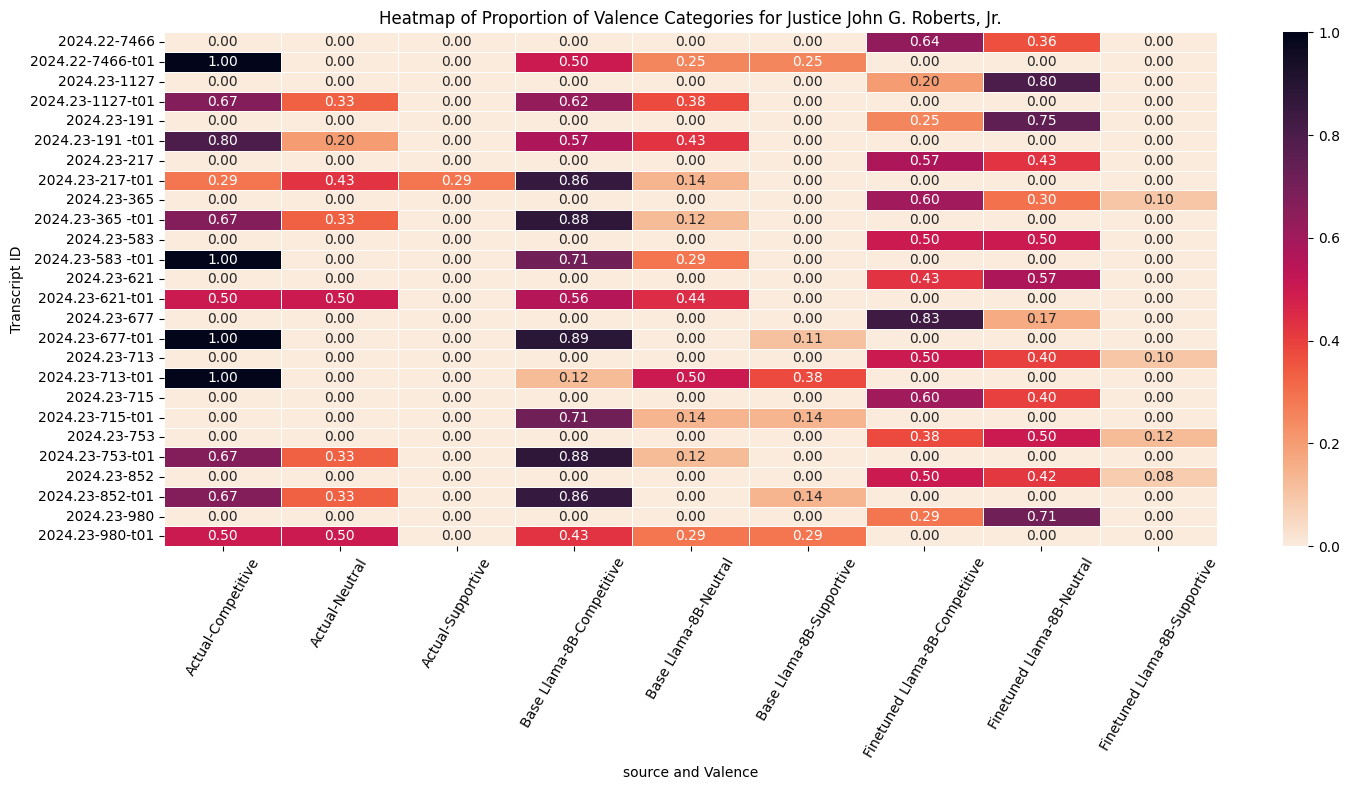

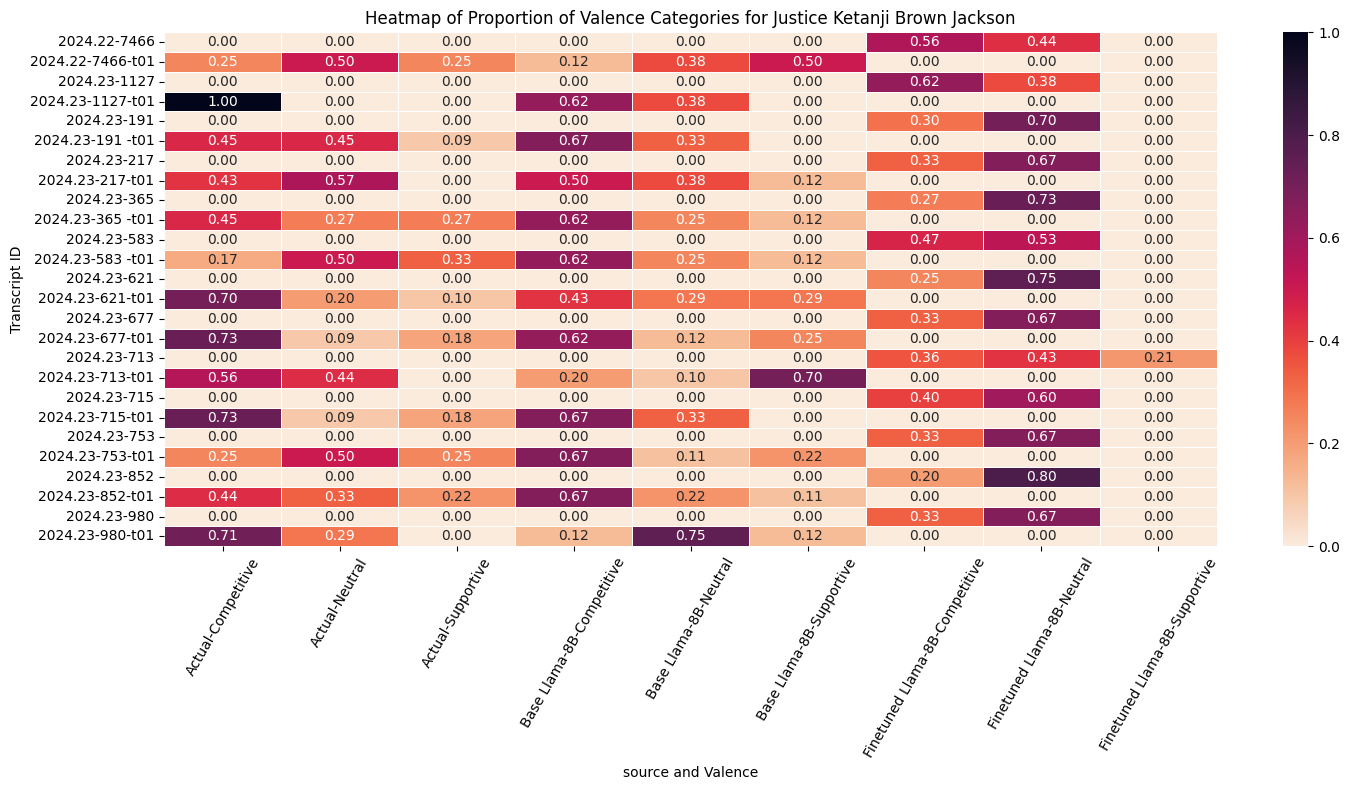

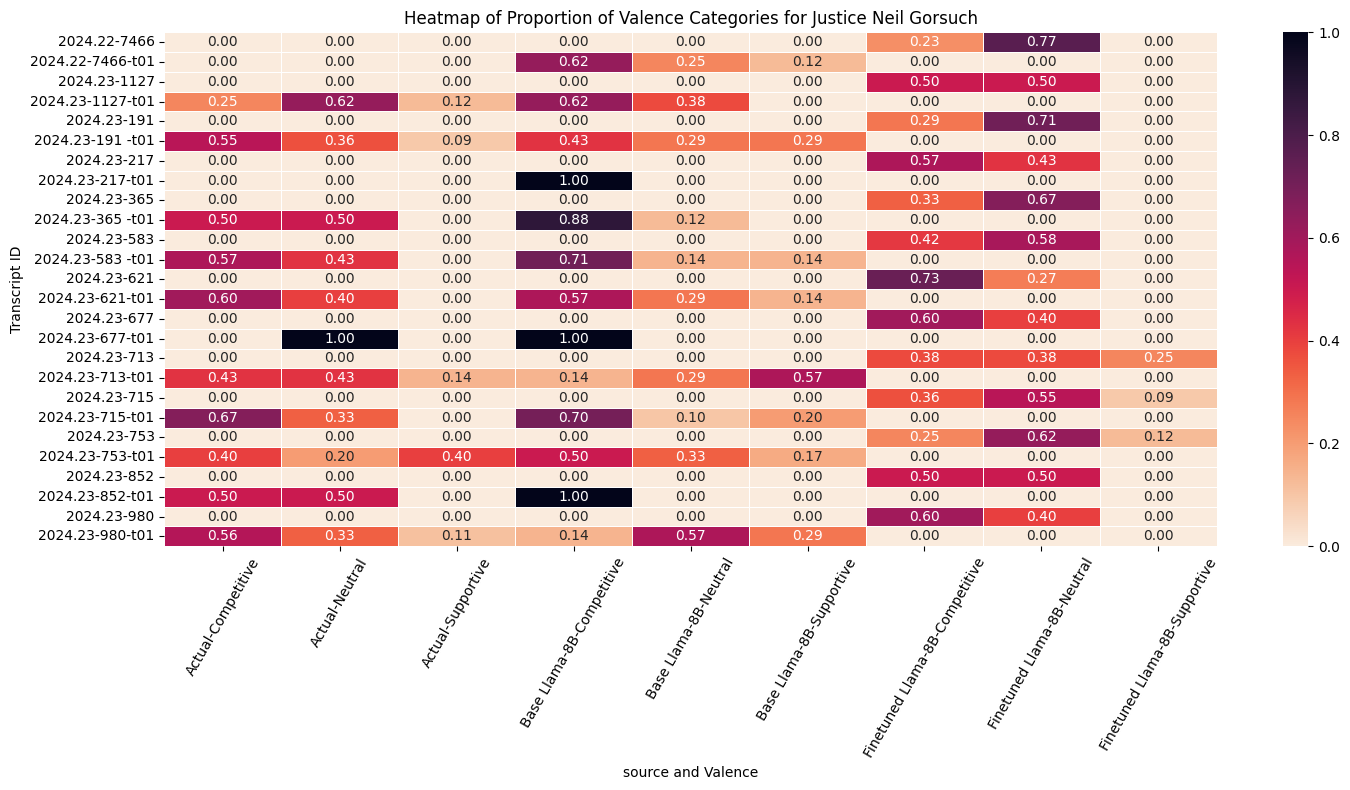

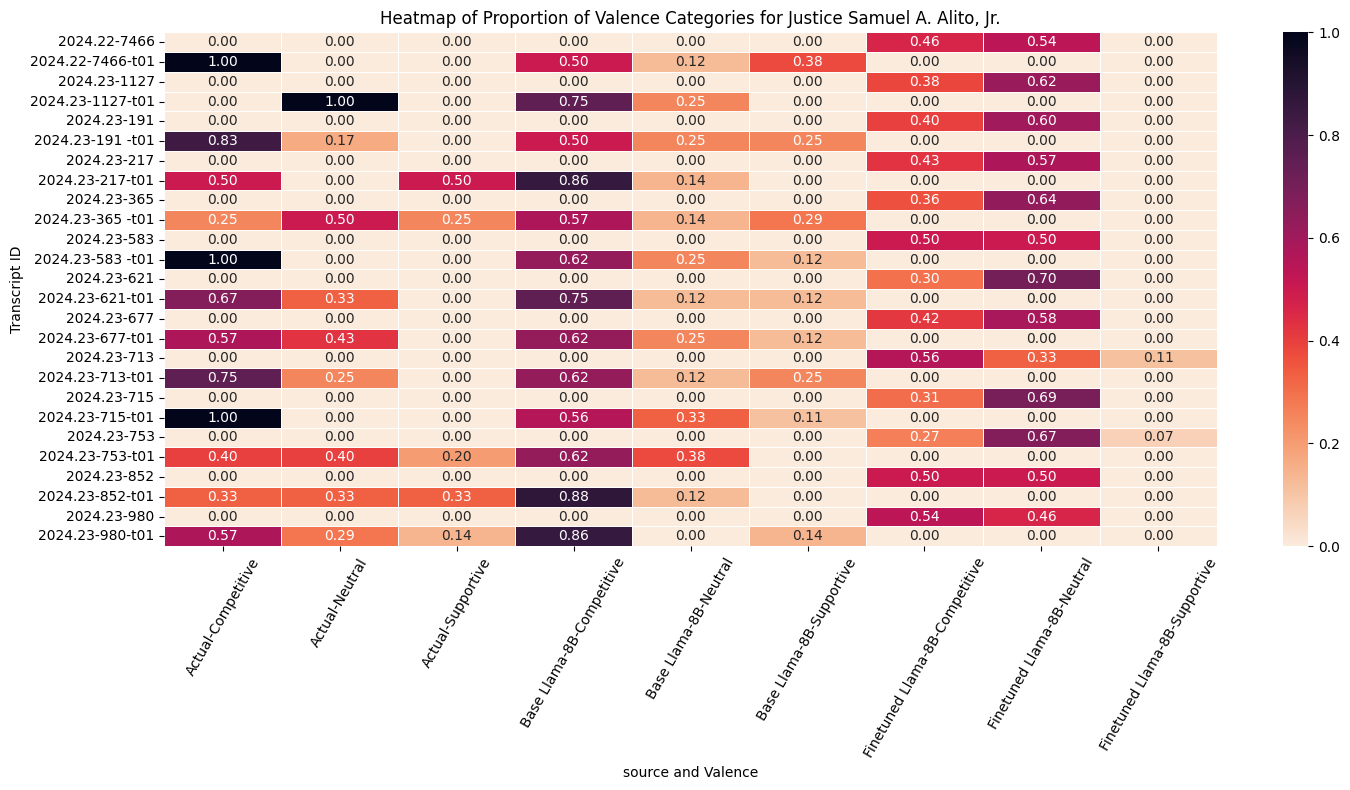

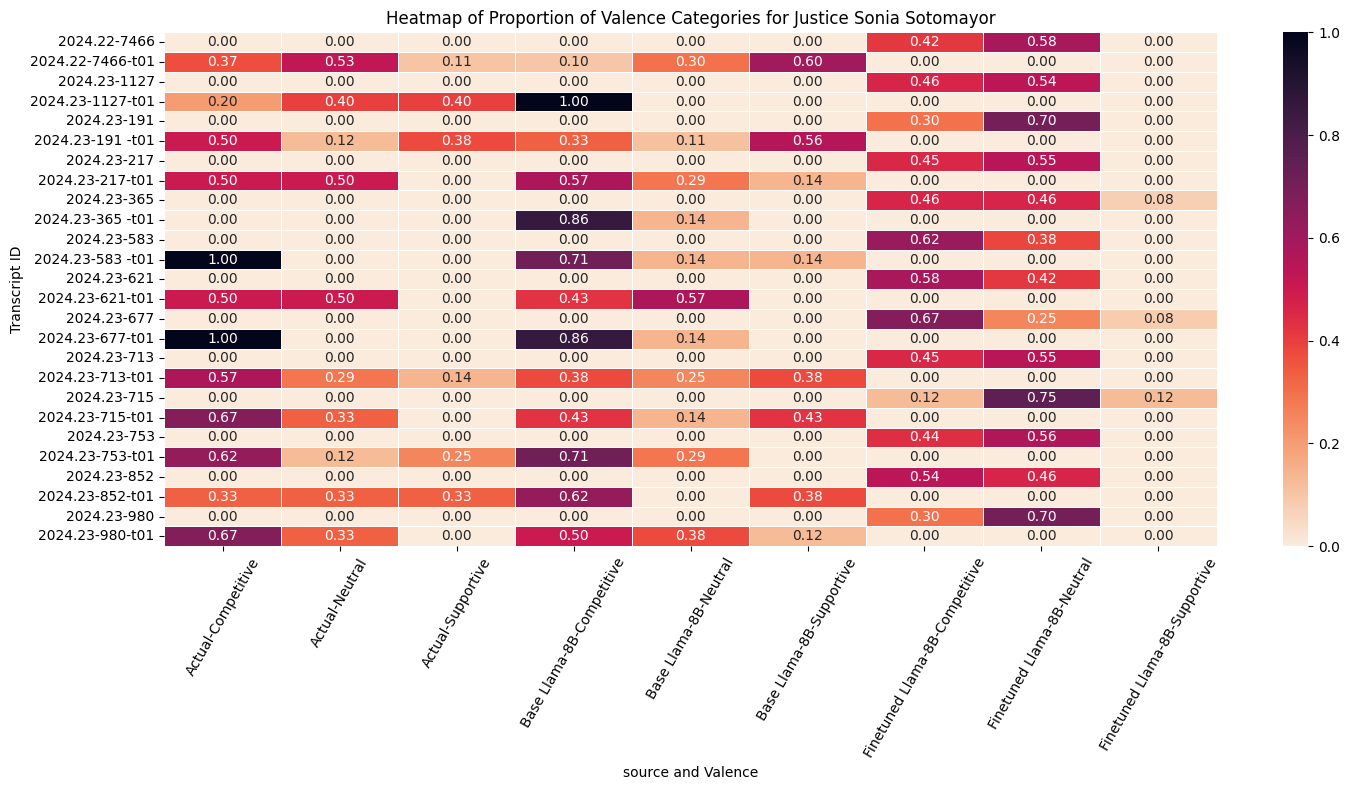

In [25]:
for justice in combined_valence_bucketed_proportions['justice'].unique():
    justice_subset = combined_valence_bucketed_proportions[combined_valence_bucketed_proportions['justice'] == justice]
    pivot_data = justice_subset.pivot_table(
        index='transcript_id', columns=['source', 'bucketed_valence'], values='proportion', fill_value=0
    )

    plt.figure(figsize=(15, 8))
    sns.heatmap(pivot_data, cmap="rocket_r", annot=True, fmt=".2f", linewidths=.5)
    plt.title(f"Heatmap of Proportion of Valence Categories for Justice {justice}")
    plt.xlabel("source and Valence")
    plt.ylabel("Transcript ID")
    plt.xticks(rotation=60)
    plt.tight_layout()
    # plt.savefig(f'figures/{justice}_heatmap_valence.png')
    plt.show()

## Combine metacog and valence/legalbench csvs

In [ ]:
dir = '/scratch/gpfs/nnadeem/llms-for-oral-arguments/finetune/outputs/OS_questions/processed'
valence_legalbench_fp = f'{dir}/dialogue_finetuned_8B_inference_compiled_valence_legalbench.csv'
metacog_only_fp = f'{dir}/dialogue_finetuned_8B_inference_compiled_metacog.csv'
out_fp = f'{dir}/dialogue_finetuned_8B_inference_compiled_all_metrics.csv'


In [ ]:
df1 = pd.read_csv(valence_legalbench_fp)
df1.head()

In [ ]:
df2 = pd.read_csv(metacog_only_fp)
df2.head()

In [ ]:
# Identify common columns (excluding the extras)
common_cols = list(set(df1.columns).intersection(df2.columns))
# Merge the two dataframes on the common columns
merged_df = pd.merge(df1, df2, on=common_cols, how="inner")

In [ ]:
merged_df.head()

In [ ]:
merged_df.to_csv(out_fp, index=False)